In [1]:
import pandas as pd
import numpy as np

#  plot confusion matrices
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn import preprocessing
from sklearn.model_selection import train_test_split


import sys
sys.path.insert(1, '../')
from py_oqat.config_algorithms import ACOConfig
from py_oqat.classifier import OQATClassifier

In [2]:
SEED = 420

def pretty_print_confusion_matrix(confusion_matrix):
    for row in confusion_matrix:
        print(row)

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        
    # print(cm)

    df_cm = pd.DataFrame(cm, index = [i for i in classes],
                  columns = [i for i in classes])
    plt.figure(figsize = (7,5))
    sns.heatmap(df_cm, annot=True, cmap=cmap)

    plt.title(title)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()



In [18]:
# Read csv file and load it into a numpy array
df = pd.read_csv('../datasets/car.csv')


# Separate features and labels into two dataframes
X = df.drop('class', axis=1)
y = df['class']

# Define the feature type for each column (discrete or continuous)
column_names = X.columns.to_list()
column_types = ['cat', 'cat', 'cat', 'cat', 'cat', 'cat']

# transform the dataframes into a numpy array
X = X.values
y = y.values

print(X.shape)
print(y.shape)

(1728, 6)
(1728,)


In [19]:
# Transform the string labels into integers
X = preprocessing.OrdinalEncoder().fit_transform(X)
y = preprocessing.LabelEncoder().fit_transform(y)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.8, random_state=SEED)

In [20]:
# Balance the training set

print("Before SMOTE")
print(pd.Series(y_train).value_counts())
# smote = SMOTE()
# X_train, y_train = smote.fit_resample(X_train, y_train)
# print("After SMOTE")
# print(pd.Series(y_train).value_counts())

Before SMOTE
0    249
1     70
2     14
3     12
dtype: int64


Decision Tree
[930  28   3   0]
[ 33 265  15   1]
[ 0  5 48  2]
[ 0 10  0 43]
Score:  0.9298626174981923


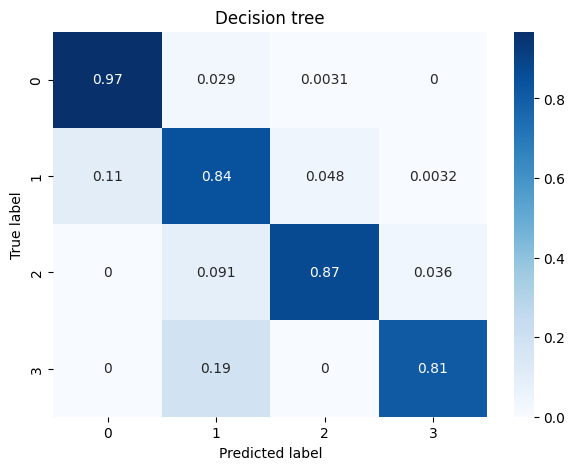

In [21]:
# Run a classification tree algorithm from sklearn
tree_model = DecisionTreeClassifier()
tree_model.fit(X_train, y_train)
y_pred_tree = tree_model.predict(X_test)
cm_tree = confusion_matrix(y_test, y_pred_tree)
print("Decision Tree")
pretty_print_confusion_matrix(cm_tree)
print("Score: ", tree_model.score(X_test, y_test))
plot_confusion_matrix(cm_tree, classes=['0', '1', '2', '3'], normalize=True, title='Decision tree')
# text_repr = tree.export_text(tree_model)
# print(text_repr)

In [22]:
# # Run the OQAT algorithm
aco_config = ACOConfig(algorithm="vertex-ac", cycles=20, ants=10, alpha=1, rho=0.99, tau_max=6., tau_min=0.01)
classifier = OQATClassifier(collision_strategy="best_score", null_strategy="weighted", heuristic="aco", heuristic_config=aco_config)
classifier.fit(X_train, y_train, column_names, column_types)
print(classifier.model)

Model for class 0 created
Score: 0.9134615384615384
Model for class 1 created
Score: 0.7596153846153846
Model for class 2 created
Score: 0.9807692307692307
Model for class 3 created
Score: 0.9615384615384616
{0: {'oqat_model': (([maint=1.00] ∨ [maint=0.00] ∨ [persons=0.00] ∨ [safety=0.00] ∨ [lug_boot=0.00]) ∧ ([safety=0.00] ∨ [buy=1.00] ∨ [buy=0.00] ∨ [persons=0.00] ∨ [maint=0.00] ∨ [doors=0.00]) ∧ ([lug_boot=2.00] ∨ [lug_boot=1.00] ∨ [maint=0.00] ∨ [safety=0.00] ∨ [doors=1.00] ∨ [persons=0.00] ∨ [persons=2.00]) ∧ ([buy=1.00] ∨ [buy=0.00] ∨ [safety=0.00] ∨ [lug_boot=0.00] ∨ [maint=2.00] ∨ [maint=3.00] ∨ [persons=0.00]) ∧ ([maint=3.00] ∨ [maint=2.00] ∨ [maint=0.00] ∨ [doors=0.00] ∨ [doors=3.00] ∨ [buy=0.00] ∨ [buy=2.00] ∨ [buy=3.00] ∨ [safety=1.00] ∨ [safety=0.00] ∨ [persons=0.00])), 'cnf_weights': [32, 15, 7, 7, 3], 'cnf_weights_norm': [0.5, 0.234375, 0.109375, 0.109375, 0.046875], 'score': 0.9134615384615384}, 1: {'oqat_model': (([safety=1.00] ∨ [safety=2.00]) ∧ ([persons=2.00] ∨ [per

In [23]:
classifier.collision_strategy = "None"
classifier.null_strategy = "None"
y_pred_set = classifier.predict(X_test, column_names)
print(y_pred_set)

[1, 0, [2, 3], 0, 2, -1, 0, 0, 0, 1, 1, 1, 0, 0, -1, 0, 0, [0, 1], 1, 1, 0, 2, 1, 1, 0, 0, 0, 0, 1, -1, [0, 2], 0, [0, 1], 1, 1, 0, 0, 1, 0, 0, [1, 3], 0, 0, 0, -1, 0, 1, 0, 2, 0, 0, 1, 0, 3, 1, 0, 0, 0, [0, 1], 0, 0, 0, 0, [0, 1], 1, [0, 1], 0, 1, [0, 2], 2, 0, 0, -1, 1, 0, [0, 1], [0, 1], 1, -1, 0, -1, 0, 1, 0, 1, 2, 0, 0, 0, 0, 0, 0, 0, -1, 0, -1, 0, 0, 0, [0, 1], 0, 1, 1, 1, [0, 1], 0, 0, 0, 0, [1, 2], 1, 1, 0, 0, -1, 0, 0, -1, 3, 0, 0, 0, 0, [0, 2], 0, 0, -1, 0, 1, 0, 0, 0, 0, 1, 0, 1, [0, 1], 0, 0, 0, 0, 0, 0, [1, 2], -1, 2, 0, 0, [0, 2], 1, 0, [0, 1], [0, 1], 1, 0, 0, 1, 1, 1, [0, 1], 0, 0, 0, 0, 1, 0, 0, 1, [0, 1], 0, 0, [0, 3], [0, 1], 0, 0, -1, [0, 1], 0, 0, 0, 3, [1, 2], 0, 0, 0, 0, 0, 1, 1, -1, 0, -1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 3, 1, 1, 0, 0, [1, 3], 3, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, 0, 0, [1, 2], 0, 0, 0, 0, 0, 0, 0, 0, 3, 1, 2, [0, 1], [0, 1], 0, 1, 0, 1, 0, 1, 1, [0, 1], [1, 2], 1, 0, 0, 0, 0, 1, -1, 1, 0, 1, [0, 1], 0, 0, 3, 0, [0, 1], [0, 

[1, 0, 2, 0, 2, 1, 0, 0, 0, 1, 1, 1, 0, 0, 3, 0, 0, 0, 1, 1, 0, 2, 1, 1, 0, 0, 0, 0, 1, 2, 2, 0, 0, 1, 1, 0, 0, 1, 0, 0, 3, 0, 0, 0, 2, 0, 1, 0, 2, 0, 0, 1, 0, 3, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 2, 2, 0, 0, 3, 1, 0, 0, 0, 1, 2, 0, 1, 0, 1, 0, 1, 2, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 2, 1, 1, 0, 0, 3, 0, 0, 2, 3, 0, 0, 0, 0, 2, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 2, 3, 2, 0, 0, 2, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 3, 0, 0, 0, 2, 0, 0, 0, 0, 3, 2, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 3, 1, 1, 0, 0, 3, 3, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 3, 1, 2, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 2, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 3, 0, 0, 0, 0, 1, 2, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 2, 3, 0, 1, 0, 3, 2, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 

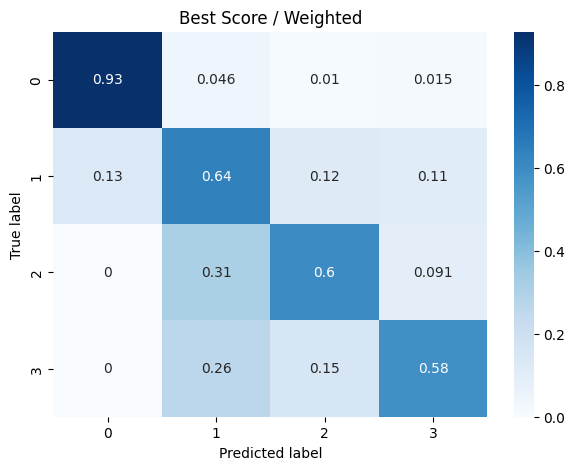

In [24]:
classifier.collision_strategy = "best_score"
classifier.null_strategy = "weighted"
y_pred_bs_w = classifier.predict(X_test, column_names)
print(y_pred_bs_w)
cm_bs_w = classifier.confusion_matrix(y_pred_bs_w, y_test)
pretty_print_confusion_matrix(cm_bs_w)
print("Score: ", classifier.score(y_pred_bs_w, y_test))
plot_confusion_matrix(np.array(cm_bs_w), classes=['0', '1', '2', '3'], normalize=True, title='Best Score / Weighted')

[1, 0, 2, 0, 2, 1, 0, 0, 0, 1, 1, 1, 0, 0, 3, 0, 0, 0, 1, 1, 0, 2, 1, 1, 0, 0, 0, 0, 1, 1, 2, 0, 0, 1, 1, 0, 0, 1, 0, 0, 3, 0, 0, 0, 1, 0, 1, 0, 2, 0, 0, 1, 0, 3, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 2, 2, 0, 0, 3, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 2, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 2, 1, 1, 0, 0, 3, 0, 0, 1, 3, 0, 0, 0, 0, 2, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 2, 1, 2, 0, 0, 2, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 3, 0, 0, 0, 1, 0, 0, 0, 0, 3, 2, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 3, 1, 1, 0, 0, 3, 3, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 3, 1, 2, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 2, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 3, 0, 0, 0, 0, 1, 2, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 2, 1, 0, 1, 0, 3, 2, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 

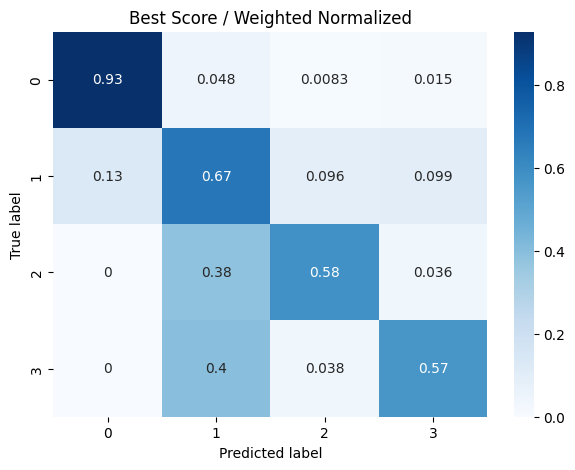

In [25]:
classifier.collision_strategy = "best_score"
classifier.null_strategy = "weighted_normalized"
y_pred_bs_wn = classifier.predict(X_test, column_names)
print(y_pred_bs_wn)
cm_bs_wn = classifier.confusion_matrix(y_pred_bs_wn, y_test)
pretty_print_confusion_matrix(cm_bs_wn)
print("Score: ", classifier.score(y_pred_bs_wn, y_test))
plot_confusion_matrix(np.array(cm_bs_wn), classes=['0', '1', '2', '3'], normalize=True, title='Best Score / Weighted Normalized')

[1, 0, 2, 0, 2, 1, 0, 0, 0, 1, 1, 1, 0, 0, 3, 0, 0, 0, 1, 1, 0, 2, 1, 1, 0, 0, 0, 0, 1, 3, 2, 0, 0, 1, 1, 0, 0, 1, 0, 0, 3, 0, 0, 0, 2, 0, 1, 0, 2, 0, 0, 1, 0, 3, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 2, 2, 0, 0, 3, 1, 0, 0, 0, 1, 3, 0, 1, 0, 1, 0, 1, 2, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 2, 1, 1, 0, 0, 3, 0, 0, 3, 3, 0, 0, 0, 0, 2, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 2, 1, 2, 0, 0, 2, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 3, 0, 0, 0, 2, 0, 0, 0, 0, 3, 2, 0, 0, 0, 0, 0, 1, 1, 2, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 3, 1, 1, 0, 0, 3, 3, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 3, 1, 2, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 2, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 3, 0, 0, 0, 0, 1, 2, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 2, 3, 0, 1, 0, 3, 2, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 

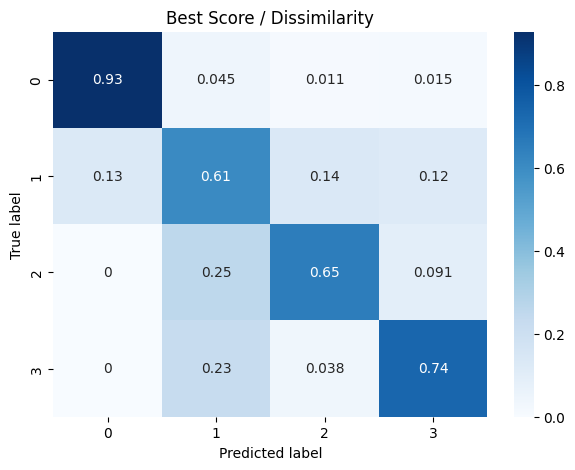

In [26]:
classifier.collision_strategy = "best_score"
classifier.null_strategy = "dissimilarity"
y_pred_bs_d = classifier.predict(X_test, column_names)
print(y_pred_bs_d)
cm_bs_d = classifier.confusion_matrix(y_pred_bs_d, y_test)
pretty_print_confusion_matrix(cm_bs_d)
print("Score: ", classifier.score(y_pred_bs_d, y_test))
plot_confusion_matrix(np.array(cm_bs_d), classes=['0', '1', '2', '3'], normalize=True, title='Best Score / Dissimilarity')

[1, 0, 3, 0, 2, 1, 0, 0, 0, 1, 1, 1, 0, 0, 3, 0, 0, 1, 1, 1, 0, 2, 1, 1, 0, 0, 0, 0, 1, 2, 2, 0, 1, 1, 1, 0, 0, 1, 0, 0, 3, 0, 0, 0, 2, 0, 1, 0, 2, 0, 0, 1, 0, 3, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 2, 2, 0, 0, 3, 1, 0, 1, 1, 1, 2, 0, 1, 0, 1, 0, 1, 2, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 2, 1, 1, 0, 0, 3, 0, 0, 2, 3, 0, 0, 0, 0, 2, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 2, 3, 2, 0, 0, 2, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 3, 1, 0, 0, 2, 1, 0, 0, 0, 3, 2, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 3, 1, 1, 0, 0, 3, 3, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 3, 1, 2, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 2, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 3, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 3, 0, 0, 0, 0, 1, 2, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 2, 3, 0, 1, 0, 3, 2, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 

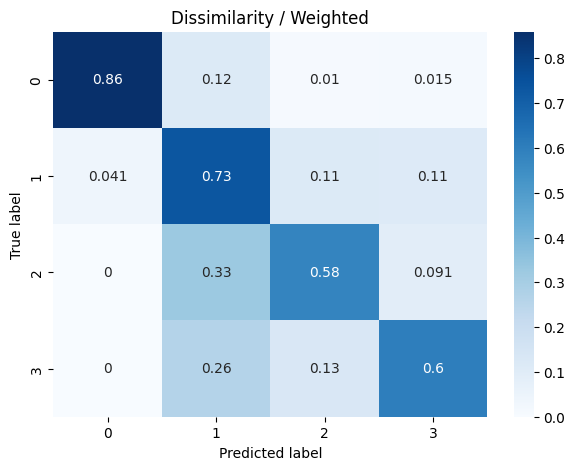

In [27]:
classifier.collision_strategy = "dissimilarity"
classifier.null_strategy = "weighted"
y_pred_d_w = classifier.predict(X_test, column_names)
print(y_pred_d_w)
cm_d_w = classifier.confusion_matrix(y_pred_d_w, y_test)
pretty_print_confusion_matrix(cm_d_w)
print("Score: ", classifier.score(y_pred_d_w, y_test))
plot_confusion_matrix(np.array(cm_d_w), classes=['0', '1', '2', '3'], normalize=True, title='Dissimilarity / Weighted')

[1, 0, 3, 0, 2, 1, 0, 0, 0, 1, 1, 1, 0, 0, 3, 0, 0, 1, 1, 1, 0, 2, 1, 1, 0, 0, 0, 0, 1, 1, 2, 0, 1, 1, 1, 0, 0, 1, 0, 0, 3, 0, 0, 0, 1, 0, 1, 0, 2, 0, 0, 1, 0, 3, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 2, 2, 0, 0, 3, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 2, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 2, 1, 1, 0, 0, 3, 0, 0, 1, 3, 0, 0, 0, 0, 2, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 2, 1, 2, 0, 0, 2, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 3, 1, 0, 0, 1, 1, 0, 0, 0, 3, 2, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 3, 1, 1, 0, 0, 3, 3, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 3, 1, 2, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 2, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 3, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 3, 0, 0, 0, 0, 1, 2, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 2, 1, 0, 1, 0, 3, 2, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 

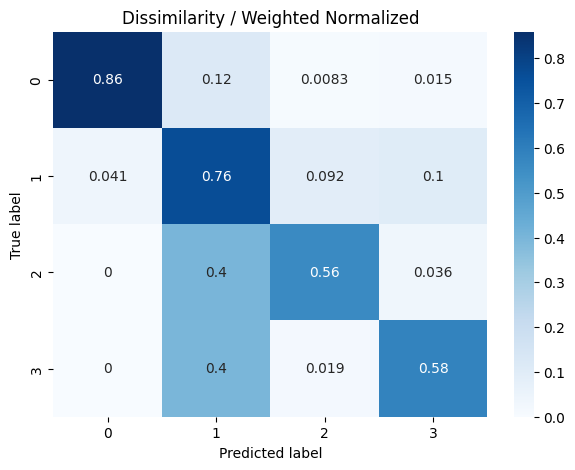

In [28]:
classifier.collision_strategy = "dissimilarity"
classifier.null_strategy = "weighted_normalized"
y_pred_d_wn = classifier.predict(X_test, column_names)
print(y_pred_d_wn)
cm_d_wn = classifier.confusion_matrix(y_pred_d_wn, y_test)
pretty_print_confusion_matrix(cm_d_wn)
print("Score: ", classifier.score(y_pred_d_wn, y_test))
plot_confusion_matrix(np.array(cm_d_wn), classes=['0', '1', '2', '3'], normalize=True, title='Dissimilarity / Weighted Normalized')

[1, 0, 3, 0, 2, 1, 0, 0, 0, 1, 1, 1, 0, 0, 3, 0, 0, 1, 1, 1, 0, 2, 1, 1, 0, 0, 0, 0, 1, 3, 2, 0, 1, 1, 1, 0, 0, 1, 0, 0, 3, 0, 0, 0, 2, 0, 1, 0, 2, 0, 0, 1, 0, 3, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 2, 2, 0, 0, 3, 1, 0, 1, 1, 1, 3, 0, 1, 0, 1, 0, 1, 2, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 2, 1, 1, 0, 0, 3, 0, 0, 3, 3, 0, 0, 0, 0, 2, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 2, 1, 2, 0, 0, 2, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 3, 1, 0, 0, 2, 1, 0, 0, 0, 3, 2, 0, 0, 0, 0, 0, 1, 1, 2, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 3, 1, 1, 0, 0, 3, 3, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 3, 1, 2, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 2, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 3, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 3, 0, 0, 0, 0, 1, 2, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 2, 3, 0, 1, 0, 3, 2, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 

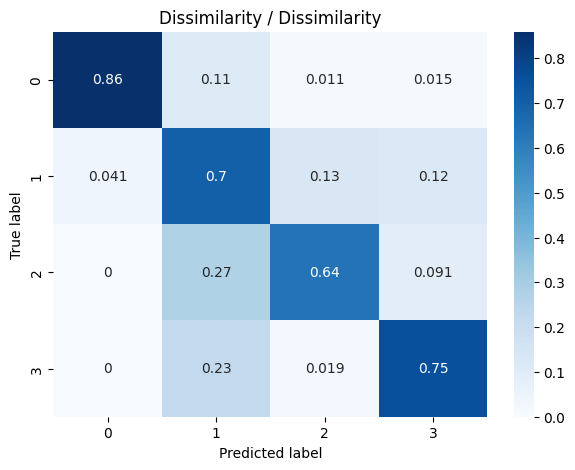

In [29]:
classifier.collision_strategy = "dissimilarity"
classifier.null_strategy = "dissimilarity"
y_pred_d_d = classifier.predict(X_test, column_names)
print(y_pred_d_d)
cm_d_d = classifier.confusion_matrix(y_pred_d_d, y_test)
pretty_print_confusion_matrix(cm_d_d)
print("Score: ", classifier.score(y_pred_bs_d, y_test))
plot_confusion_matrix(np.array(cm_d_d), classes=['0', '1', '2', '3'], normalize=True, title='Dissimilarity / Dissimilarity')

In [30]:

for learning_class, model in classifier.model.items():
    print(f'Class: {learning_class}')
    print(f'Score: {model["score"]}')
    for i, clause in enumerate(model['oqat_model'].model.clauses):
        print(f'\t{model["cnf_weights"][i]: ^4} Clause: {clause}')

print(f'    X           y_test   bs / w    bs / wn   bs / d      d / w    d / wn    d / d   sets')
for i in range(len(y_test)):
    print(X_test[i], f'{y_test[i]: ^9}', f'{y_pred_bs_w[i]: ^9}', f'{y_pred_bs_wn[i]: ^9}', f'{y_pred_bs_d[i]: ^9}', f'{y_pred_d_w[i]: ^9}', f'{y_pred_d_wn[i]: ^9}', f'{y_pred_d_d[i]: ^9}', f'{y_pred_set[i]}')

Class: 0
Score: 0.9134615384615384
	 32  Clause: ([maint=1.00] ∨ [maint=0.00] ∨ [persons=0.00] ∨ [safety=0.00] ∨ [lug_boot=0.00])
	 15  Clause: ([safety=0.00] ∨ [buy=1.00] ∨ [buy=0.00] ∨ [persons=0.00] ∨ [maint=0.00] ∨ [doors=0.00])
	 7   Clause: ([lug_boot=2.00] ∨ [lug_boot=1.00] ∨ [maint=0.00] ∨ [safety=0.00] ∨ [doors=1.00] ∨ [persons=0.00] ∨ [persons=2.00])
	 7   Clause: ([buy=1.00] ∨ [buy=0.00] ∨ [safety=0.00] ∨ [lug_boot=0.00] ∨ [maint=2.00] ∨ [maint=3.00] ∨ [persons=0.00])
	 3   Clause: ([maint=3.00] ∨ [maint=2.00] ∨ [maint=0.00] ∨ [doors=0.00] ∨ [doors=3.00] ∨ [buy=0.00] ∨ [buy=2.00] ∨ [buy=3.00] ∨ [safety=1.00] ∨ [safety=0.00] ∨ [persons=0.00])
Class: 1
Score: 0.7596153846153846
	 92  Clause: ([safety=1.00] ∨ [safety=2.00])
	 56  Clause: ([persons=2.00] ∨ [persons=1.00])
	 13  Clause: ([maint=3.00] ∨ [maint=2.00] ∨ [safety=1.00] ∨ [buy=2.00] ∨ [buy=1.00])
	 9   Clause: ([doors=2.00] ∨ [persons=1.00] ∨ [buy=0.00] ∨ [buy=2.00] ∨ [maint=3.00] ∨ [maint=1.00])
	 6   Clause: ([lug_bo